In [ ]:
!pip install tensorflow pandas tqdm scikit-learn gensim Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.3 MB/s eta 0:00:00


# LSTM Implementation

In this LSTM implementation endeavor, we looking into the implementation of LSTM-based model to do sentiment analysis for case below:

https://www.kaggle.com/code/kevinismail/training-lstm-sentiment-analysis-bahasa

This endeavor aim to create an LSTM model with high accuracy.

In [ ]:
import tensorflow;

import pandas;
from sklearn.model_selection import train_test_split;
from tqdm import tqdm;
import re;

import json;

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory;

In [ ]:
from google.colab import drive;
drive.mount("/content/drive");

Mounted at /content/drive


## Data Loading & Exploration

First is to load the dataset with pandas. The file separator is [TAB] so we set it to `\\t+`.

This part also explore the dataset.

In [ ]:
dataframe = pandas.read_csv("/content/drive/MyDrive/Collab Dataset/nlp-dl-self-assignment/raw_dataset.csv", sep = "\\t+");


print("Data Profile Model");
print("============================================================");
print(dataframe.count());

sentiment_negative = len(dataframe[dataframe["sentimen"] == -1]);
sentiment_neutral = len(dataframe[dataframe["sentimen"] == 0]);
sentiment_positive = len(dataframe[dataframe["sentimen"] == 1]);
print(f"Data with sentiment negative (-1) \t: {sentiment_negative}");
print(f"Data with sentiment neutral (0)   \t: {sentiment_neutral}");
print(f"Data with sentiment positive (1)  \t: {sentiment_positive}");

dataframe.head()

<ipython-input-4-b221262af985>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataframe = pandas.read_csv("/content/drive/MyDrive/Collab Dataset/nlp-dl-self-assignment/raw_dataset.csv", sep = "\\t+");


Data Profile Model
sentimen    10806
Tweet       10806
dtype: int64
Data with sentiment negative (-1) 	: 2887
Data with sentiment neutral (0)   	: 5327
Data with sentiment positive (1)  	: 2592


,sentimen,Tweet
0,-1,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
1,-1,kita lanjutkan saja diam ini hingga kau dan ak...
2,1,doa rezeki tak putus inna haa zaa larizquna ma...
3,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...
4,-1,aku tak faham betul jenis orang malaysia yang ...


# Train-Test-Split

The ratio used in this project will be 7 : 1,5 : 1,5

| Segment | Ratio |
|---|---|
| `train` | 7 |
| `test` | 1,5 |
| `val` | 1,5 |

This can be done by applying the following algorithm below:

> 1. Apply train-test split to whole data by 7 for train and 3 for the rest
> 2. Apply train-test split to "rest" data by 5 for first half and 5 for the second half

This will split the data into 7 : 1,5 : 1,5 ratio.

In [ ]:
features = dataframe["Tweet"];
labels = dataframe["sentimen"];

# Splitting data for training and testing & Validation
# First is to split the data into 7 : 3
feature_train, feature_test, label_train, label_test = train_test_split(
    features,
    labels,
    train_size = 0.7,
    test_size = 0.3, # test and val
    random_state = 42
);

# With 3 of 10 portion left, then to split the data into 1,5 : 1,5, we can do 0,5 : 0,5
feature_test, feature_val, label_test, label_val = train_test_split(
    feature_test, # Taken from line 6
    label_test, # Taken from line 6
    train_size = 0.5,
    test_size = 0.5,
    random_state = 42
);

## Dataset Pre-Processing

NLP / NLU cases are known as not easy dataset pre-processing. <br />
Imagine converting your text into numbers just to make computer understand what you try to do. <br />
Public dataset also challenging. <br />
I mean, what is this? Bahasa Indonesia? Javanese? Sundanese? Malay? English? How???

![image.png](attachment:image.png)

Enough the ranting, let's start with data normalization before we going for the actual pre-processing concept for NLU:

1. Make all words in the dataset lower case
2. Remove any punctuation characters
3. Remove Bahasa Indonesia stop words
4. Label's One-Hot Encoding


In [ ]:
# Call out step 1
feature_train = feature_train.str.lower();
feature_test = feature_test.str.lower();
feature_val = feature_val.str.lower();

# Call out step 2
def remove_punctuation (text: str):
    punct_regex = r'[^\w\s]';
    clean_text = re.sub(punct_regex, "", text);
    return clean_text;

feature_train = feature_train.apply(lambda x: remove_punctuation(x));
feature_test = feature_test.apply(lambda x: remove_punctuation(x));
feature_val = feature_val.apply(lambda x: remove_punctuation(x));

# Call out step 3
stopword_factory = StopWordRemoverFactory();
stopwords = stopword_factory.get_stop_words();

def remove_stopword (text: str):
    # Splice the sentence into words
    words = text.split();

    # If word in current loop is not available in stopwords array, then save it to clean_words
    clean_words = [i for i in words if i not in stopwords];

    # Unsplice words into one sentence.
    return " ".join(clean_words);

feature_train = feature_train.apply(lambda x: remove_stopword(x));
feature_test = feature_test.apply(lambda x: remove_stopword(x));
feature_val = feature_val.apply(lambda x: remove_stopword(x));

# Call out step 4
label_train = pandas.get_dummies(label_train, prefix = "sentiment_");
label_test = pandas.get_dummies(label_test, prefix = "sentiment_");
label_val = pandas.get_dummies(label_val, prefix = "sentiment_");

There are few things to complete within dataset pre-processing for NLU case:

### 1. Slang Word Standardization
We have such beautiful community that keep texting with slang words. In other word, not removing slang-words may cause problems when stemming. So, this part will replace all those slang words, into standard one.

But we also had beautiful community that provides such slang dataset.
https://github.com/louisowen6/NLP_bahasa_resources/tree/master

The algorithm of this task is as follow:

> 1. Load `combined_slang_words.json` file
> 2. Loop through features data <br />
> 2.1 Splice the sentence <br />
> 2.2 For every word within sentence <br />
> 2.2.1 If this word is found on slang, then replace it with standard one <br />
> 2.2.2 Else, ignore. <br />
> 2.3 Unsplice the sentence <br />
> 3. Save the data

In [ ]:
slang_db = json.load(open("/content/drive/MyDrive/Collab Dataset/nlp-dl-self-assignment/resources/combined_slang_words.json", "r"));

def slang_word_standardizer(text: str):
    words = text.split();
    clean_words = [slang_db.get(i, i) for i in words];

    return " ".join(clean_words);

feature_train = feature_train.apply(lambda x: slang_word_standardizer(x));
feature_test = feature_test.apply(lambda x: slang_word_standardizer(x));
feature_val = feature_val.apply(lambda x: slang_word_standardizer(x));


### 2. Lexical Analysis

This step normalize your text. Kind of doing "standardization". This step will include *Stemming*.

#### Stemming

Bahasa Indonesia had so many unnormal words ruling. By mean *unnormal*:

| Unnormal word | Stemming result |
|---|---|
| Memberikan | beri |
| Perekonomian | ekonomi |
| Pertumbuhan | tumbuh |
| Membanggakan | bangga |

*Bare with me

#### Lemmatization
Unfortunately, Sastrawi haven't made for Lemmatization we will skip the lemmatization for now. But if this feature exists, I'll prefer this than just stemming.

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory;

factory = StemmerFactory();
stemmer = factory.create_stemmer();

tqdm.pandas();

# Apply stemmer
print("Stemming feature train");
feature_train = feature_train.progress_apply(lambda x: stemmer.stem(x));

print("Stemming feature test");
feature_test = feature_test.progress_apply(lambda x: stemmer.stem(x));

print("Stemming feature val");
feature_val = feature_val.progress_apply(lambda x: stemmer.stem(x));

Stemming feature train


100%|██████████| 7564/7564 [21:43<00:00,  5.80it/s]


Stemming feature test


100%|██████████| 1621/1621 [03:12<00:00,  8.41it/s]


Stemming feature val


100%|██████████| 1621/1621 [02:59<00:00,  9.01it/s]


### 3. Tokenization & Vectorization / Word Embedding

After Stemming, we will start into Tokenization & Vectorization.

#### Tokenization

Hence I got this sentence below:

"Hallo everynyan. How are you? Fine thank you. I wish I were a bird."

I can tokenize things into:

`[3, 4, 5, 6, 1, 7, 8, 1, 2, 9, 2, 10, 11, 12]`

This can be happen because word `you` in this corpus (sentence) is tokenized as `1` since it is showing two times and shown first. Notice that word `I` denoted as 2. The rest are just less frequently shown so it turned into 3, 4, 5, 6, 7, 8, 9, 10, 11, and 12 respectively.

The example above, was a tokenization with 1 word for every respective token.

The Tokenization will be done using manual data manipulation. And I choosed to tokenize the corpus word per word.

In [ ]:
# Apply tokenization
print("Tokenizing feature train");
tokenized_train = feature_train.progress_apply(lambda x: x.split());

print("Tokenizing feature test");
tokenized_test = feature_test.progress_apply(lambda x: x.split());

print("Tokenizing feature val");
tokenized_val = feature_val.progress_apply(lambda x: x.split());

print("\n\nTokenization result sample");
print("==============================");

print(f"Normal \t\t\t: {feature_train.iloc[0]}");

print(f"Tokenized version \t: {tokenized_train.iloc[0]}");

Tokenizing feature train


100%|██████████| 7564/7564 [00:00<00:00, 387016.96it/s]


Tokenizing feature test


100%|██████████| 1621/1621 [00:00<00:00, 397089.52it/s]


Tokenizing feature val


100%|██████████| 1621/1621 [00:00<00:00, 407148.14it/s]



Tokenization result sample
Normal 			: kamu ret sabar takkkk aku ipx pon tidak tukar
Tokenized version 	: ['kamu', 'ret', 'sabar', 'takkkk', 'aku', 'ipx', 'pon', 'tidak', 'tukar']


#### Vectorization

Since two vectorization function are required, the Vectorization will be done using Word2Vec Skip Gram and Fast Text.

After reading fast the dataset, the agreement are as follow:

1. Every text within the tweet dataset are not more than 280.
2. A tweet are more likely to be pro-found context after reading 8 to 14 words. Since the lowest number from it was 8, so I choose 8.
3. The valid tweet is a tweet that has at least 1 word / character.
4. Since I don't want to add "stride" to the text, I will set the skip gram as 1.

Those numbers will be set as configurations below.


In [ ]:
from gensim.models import Word2Vec;
from tensorflow.keras.preprocessing.sequence import pad_sequences;
import numpy;

In [ ]:
# CONFIG
tweet_max_size = 280; # Embedding Dims & Max sequence length
context_profound = 8; # Window
minimum_valid_length = 1; # Minlen
skip_gram_config = 1; # Sg

The process of making Word Embedding engine will be performed with OOP technique.

In [208]:
# Merge train, test, val data for embedding
merged_splits = pandas.concat([tokenized_train, tokenized_test, tokenized_val]);

# Using train data, train to embed the data.
w2v_model = Word2Vec(
    sentences = merged_splits,
    vector_size = tweet_max_size,
    window = context_profound,
    min_count = minimum_valid_length,
    workers = 10, # Let's test the A100 machine :3
    sg = skip_gram_config
);

w2v_model.train(merged_splits, total_examples = len(merged_splits), epochs = 25);

In [ ]:
len(merged_splits)

10806

In [209]:
print("Training Result");
print("=============================");
print(f"Total vocabulary saved: {len(w2v_model.wv)}");

Training Result
Total vocabulary saved: 17674


#### Converting word vectors into DNN readable format

### Convert data splits into Pad Sequences

This endeavor will converting those tokenized sentences into DNN readable format.

In [229]:
# Extract word vectors for each tokenized sequence
vectorized_train = [];
vectorized_test = [];
vectorized_val = [];

for split in [tokenized_train, tokenized_test, tokenized_val]:
    split_embeddings = [];

    for texts in tqdm(split):
        sequence_embeddings = [];

        sequence_embeddings = [w2v_model.wv[token] if token in w2v_model.wv else [0] * tweet_max_size for token in texts];
        numpy_embedding = numpy.array(sequence_embeddings);
        split_embeddings.append(numpy_embedding);

    # Pad or truncate sequences to make them uniform in length
    padded_sequences = pad_sequences(
        split_embeddings,
        maxlen = tweet_max_size,
        padding = "post",
        truncating = "post",
        dtype='float32'
    );

    if(split is tokenized_train):
        vectorized_train = padded_sequences;
    elif(split is tokenized_test):
        vectorized_test = padded_sequences;
    else:
        vectorized_val = padded_sequences;

100%|██████████| 1621/1621 [00:00<00:00, 38045.97it/s]


## Model Architecture

This is where Model Architecture being implemented. As usual, the implementation of Model Architecture will be done using OOP technique.

In [253]:
w2v_weight = w2v_model.wv.vectors;

vectorized_train.shape, len(w2v_model.wv), w2v_weight.shape

((7564, 280, 280), 17674, (17674, 280))

In [240]:
import tensorflow;
from tensorflow.keras.models import Sequential;
from tensorflow.keras.layers import Input, Dense, Embedding, BatchNormalization, LSTM, Bidirectional, Flatten, TimeDistributed, Reshape;

import matplotlib.pyplot as plt;

from tensorflow.keras.utils import plot_model;
from tensorflow.keras.callbacks import EarlyStopping;

In [256]:
class BLSTMModel:
  def __init__(self):
    self.input = Input(shape=(tweet_max_size,));
    self.embedding = Embedding(
        input_dim = len(w2v_model.wv),
        weights = [w2v_weight],
        output_dim = tweet_max_size,
        name = "embedding"
    );

    self.encoder = Bidirectional(
        LSTM(
            units = 512,
            activation = "tanh",
            recurrent_initializer = 'glorot_uniform',
            return_sequences = True),
        name = "encoder"
    );

    self.decoder = LSTM(
        units = 256,
        activation = "tanh",
        recurrent_initializer = 'glorot_uniform',
        return_sequences = True,
        name = "decoder"
    );

    # self.bn1 = BatchNormalization(name = "bn1");
    self.dense1 = Dense(128, activation = "relu", name = "dense1");
    self.output = TimeDistributed(Dense(3, activation = "softmax", name = "output"));

  # Early stopping after loss are not improved for some epochs
  def _callback_early_stopping(self):
      early_stopping_tolerance = 10;
      return EarlyStopping(
          monitor = "val_accuracy",
          patience = early_stopping_tolerance,
          restore_best_weights = True
      );

  def build_model(self):
      model = Sequential(name = "blstm.202405012148");

      model.add(self.input);

      model.add(self.embedding);


      model.add(self.encoder);
      model.add(self.decoder);

      # model.add(self.bn1);

      model.add(self.dense1);
      model.add(self.output);

      model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"]);

      return model;

  def fitting(self):
      model = self.build_model();
      model.summary();

      plot_model(model, to_file = ("model_architecture.png"), show_shapes = True);


      history = model.fit(
          vectorized_train,
          label_train,
          epochs = 300,
          batch_size = 64,
          validation_data = (vectorized_val, label_val),
          callbacks = [self._callback_early_stopping()]
      );

      # Plot training history
      plt.plot(history.history['loss'], label='Training Loss');
      plt.plot(history.history['val_loss'], label='Validation Loss');
      plt.xlabel('Epoch');
      plt.ylabel('Loss');
      plt.legend();
      plt.show();

      return model;

In [257]:
blstm = BLSTMModel();
model = blstm.fitting();

test_loss, test_acc = model.evaluate(vectorized_test, label_test)
print(f'Test accuracy BLSTM: {test_acc}')

Model: "blstm.202405012148"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 280)          4948720   
                                                                 
 decoder (LSTM)              (None, 280, 256)          549888    
                                                                 
 dense1 (Dense)              (None, 280, 128)          32896     
                                                                 
 time_distributed_8 (TimeDi  (None, 280, 3)            387       
 stributed)                                                      
                                                                 
Total params: 5531891 (21.10 MB)
Trainable params: 5531891 (21.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'blstm.202405012148' (type Sequential).
    
    Input 0 of layer "decoder" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 280, 280, 280)
    
    Call arguments received by layer 'blstm.202405012148' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 280, 280), dtype=float32)
      • training=True
      • mask=None


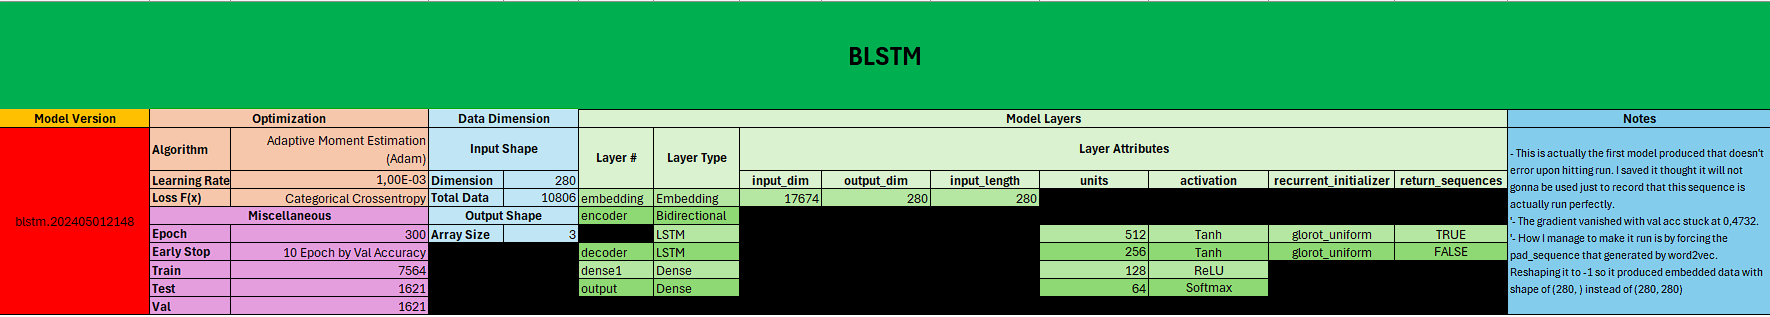